In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import ast
from torch.utils.data import Dataset, DataLoader
from torch.optim import AdamW
import math

In [2]:
def compute_load_balancing_loss(router_probs, expert_indices, num_experts):
    batch_size = router_probs.shape[0]
    
    # f_i: fraction of tokens routed to expert i
    # Count how many tokens are assigned to each expert
    expert_counts = torch.zeros(num_experts, device=router_probs.device)
    for i in range(num_experts):
        expert_counts[i] = (expert_indices == i).float().sum()
    f_i = expert_counts / batch_size  # [num_experts]
    
    # P_i: mean router probability for expert i across all tokens
    P_i = router_probs.mean(dim=0)  # [num_experts]
    
    # Load balancing loss: N * sum(f_i * P_i)
    # This is minimized when experts are used uniformly
    load_balance_loss = num_experts * (f_i * P_i).sum()
    
    return load_balance_loss


In [3]:
class LowRankExpert(nn.Module):
    def __init__(self, in_dim, out_dim, rank):
        super().__init__()
        self.A = nn.Linear(rank, out_dim, bias=False)
        self.B = nn.Linear(in_dim, rank, bias=False)

    def forward(self, x):
        return self.A(self.B(x))

In [4]:
class MoEWithLoadBalancing(nn.Module):
    def __init__(self, in_dim, out_dim, num_experts, dropout=0.0, top_k=1):
        super().__init__()
        if top_k != 1:
            raise NotImplementedError("Top-k is not implemented for MoE")
        self.top_k = top_k
        self.in_dim = in_dim
        self.out_dim = out_dim
        self.num_experts = num_experts

        # self.experts = nn.ModuleList([nn.Linear(in_dim, out_dim) for _ in range(num_experts)])
        self.experts = nn.ModuleList([LowRankExpert(in_dim, out_dim, 4) for _ in range(num_experts)])

    def forward(self, x, expert_probs, return_load_balance_loss=False):
        B, S, D = x.shape

        if expert_probs.shape != (B, self.num_experts):
            raise ValueError(f"Expert probabilities must be of shape (B, num_experts), got {expert_probs.shape}")
        
        expert_idx = torch.argmax(expert_probs, dim=-1)

        x_out = torch.zeros(B, S, self.out_dim, device=x.device, dtype=x.dtype)

        for i, expert in enumerate(self.experts):
            mask = expert_idx == i
            if mask.any():
                x_out[mask, :, :] = expert(x[mask, :, :])

        if return_load_balance_loss:
            lb_loss = compute_load_balancing_loss(expert_probs, expert_idx, self.num_experts)
            return x_out, expert_idx, lb_loss
        
        return x_out, expert_idx


In [5]:
class TransformerBlockWithLoadBalancing(nn.Module):
    def __init__(self, dim, n_heads, mlp_ratio=4.0, dropout=0.0, is_causal=True, 
                 use_moe=False, num_experts=4, router_idx=None, verbose_router=False):
        super().__init__()
        self.dim = dim
        self.n_heads = n_heads
        self.mlp_ratio = mlp_ratio
        self.num_experts = num_experts
        self.dropout = dropout
        self.router_idx = router_idx
        self.is_causal = is_causal
        self.verbose_router = verbose_router

        self.norm1 = nn.LayerNorm(dim)
        self.norm2 = nn.LayerNorm(dim)

        self.use_moe = use_moe
        if use_moe:
            if router_idx is None:
                raise ValueError("router_idx must be provided when using MoE")
            self.router = nn.Linear(dim, num_experts)
            self.qkv = MoEWithLoadBalancing(dim, 3 * dim, num_experts, dropout=dropout)
            self.o = MoEWithLoadBalancing(dim, dim, num_experts, dropout=dropout)
            self.mlp_in = MoEWithLoadBalancing(dim, int(dim * mlp_ratio), num_experts, dropout=dropout)
            self.mlp_out = MoEWithLoadBalancing(int(dim * mlp_ratio), dim, num_experts, dropout=dropout)
        else:
            self.qkv = nn.Linear(dim, 3 * dim)
            self.o = nn.Linear(dim, dim)
            self.mlp_in = nn.Linear(dim, int(dim * mlp_ratio))
            self.mlp_out = nn.Linear(int(dim * mlp_ratio), dim)

    def forward(self, x, return_load_balance_loss=False):
        B, S, D = x.shape
        total_lb_loss = 0.0
        
        # Attention block
        if self.use_moe:
            router_out = self.router(x[:, self.router_idx])
            expert_probs = F.softmax(router_out, dim=-1)
            
            if self.verbose_router:
                top_experts = torch.argmax(expert_probs, dim=-1)
                counts = torch.bincount(top_experts.flatten(), minlength=self.num_experts)
                usage = counts.float() / counts.sum() * 100
                print(f"Expert usage (%): {[f'{u:.1f}' for u in usage.tolist()]}")
            
            # QKV projection
            if return_load_balance_loss:
                qkv, _, lb_loss_qkv = self.qkv(x, expert_probs, return_load_balance_loss=True)
                total_lb_loss += lb_loss_qkv
            else:
                qkv, _ = self.qkv(x, expert_probs)
        else:
            qkv = self.qkv(x)

        # Split into Q, K, V and compute attention
        q, k, v = qkv.split(D, dim=2)
        q = q.view(B, S, self.n_heads, D // self.n_heads).permute(0, 2, 1, 3)
        k = k.view(B, S, self.n_heads, D // self.n_heads).permute(0, 2, 1, 3)
        v = v.view(B, S, self.n_heads, D // self.n_heads).permute(0, 2, 1, 3)
        
        attn_out = F.scaled_dot_product_attention(q, k, v, is_causal=self.is_causal)
        attn_out = attn_out.permute(0, 2, 1, 3).contiguous().view(B, S, D)
        
        # Output projection
        if self.use_moe:
            if return_load_balance_loss:
                attn_out, _, lb_loss_o = self.o(attn_out, expert_probs, return_load_balance_loss=True)
                total_lb_loss += lb_loss_o
            else:
                attn_out, _ = self.o(attn_out, expert_probs)
        else:
            attn_out = self.o(attn_out)
        
        x = self.norm1(x + attn_out)
        
        # MLP block
        if self.use_moe:
            if return_load_balance_loss:
                mlp_out, _, lb_loss_mlp_in = self.mlp_in(x, expert_probs, return_load_balance_loss=True)
                total_lb_loss += lb_loss_mlp_in
            else:
                mlp_out, _ = self.mlp_in(x, expert_probs)
            
            mlp_out = F.gelu(mlp_out)
            
            if return_load_balance_loss:
                mlp_out, _, lb_loss_mlp_out = self.mlp_out(mlp_out, expert_probs, return_load_balance_loss=True)
                total_lb_loss += lb_loss_mlp_out
            else:
                mlp_out, _ = self.mlp_out(mlp_out, expert_probs)
        else:
            mlp_out = F.gelu(self.mlp_in(x))
            mlp_out = self.mlp_out(mlp_out)
        
        x = self.norm2(x + mlp_out)
        
        if return_load_balance_loss:
            return x, total_lb_loss
        return x


In [6]:
# Define vocabulary and encoding/decoding
vocab = "0123456789ri+=_"
vocab_size = len(vocab)

def encode(s):
    return [vocab.index(c) for c in s]

def decode(l):
    return ''.join([vocab[i] for i in l])

IGNORE_INDEX = vocab_size - 1
print(f"Vocabulary: {vocab}")
print(f"Vocab size: {vocab_size}")
print(f"Expected starting loss: {math.log(vocab_size)}")

Vocabulary: 0123456789ri+=_
Vocab size: 15
Expected starting loss: 2.70805020110221


In [7]:
df = pd.read_csv("../data/train_64k.csv")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

X = torch.tensor(df['seq'].apply(ast.literal_eval).tolist()).to(device)
print(f"Dataset size: {X.shape[0]} sequences")
print(f"Sequence length: {X.shape[1]}")
# Create loss mask (only compute loss on the output part)
loss_mask = torch.ones_like(X).to(device)
loss_mask[:, :10] = 0  # Don't compute loss on input
print(f"Loss mask: {loss_mask[0]}")

Using device: cuda
Dataset size: 64000 sequences
Sequence length: 14
Loss mask: tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1], device='cuda:0')


In [17]:
class RRMWithLoadBalancing(nn.Module):
    def __init__(self, d_model, n_heads, max_recursions, vocab_size, num_experts, 
                 context_len, router_idx, fact_vector_idx):
        super().__init__()
        self.max_recursions = max_recursions
        self.context_len = context_len
        self.fact_vector_idx = fact_vector_idx
        self.tau = 0.5
    
        self.encoder = nn.Embedding(vocab_size, d_model)
        

        self.router_idx = router_idx
        
        self.recursive_block = TransformerBlockWithLoadBalancing(
            d_model, n_heads, is_causal=False,
            use_moe=True, num_experts=num_experts, 
            router_idx=router_idx, verbose_router=False
        )

        self.preprocess_block = TransformerBlockWithLoadBalancing(
            d_model, n_heads, is_causal=False,
            use_moe=False, num_experts=1
        )

        self.Wk = nn.Linear(d_model, d_model//4, bias=False)
        self.Wq = nn.Linear(d_model, d_model//4, bias=False)
    
        self.gate = nn.Linear(d_model, d_model)

        self.causal_block = TransformerBlockWithLoadBalancing(
            d_model, n_heads, is_causal=True,  # ✅ Causal
            use_moe=False, num_experts=1,
            router_idx=router_idx
        )
        
        self.decoder = nn.Linear(d_model, vocab_size)
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.to(self.device)

    def pool(self, x):
        return x.mean(dim=1)

    def forward(self, x, return_load_balance_loss=False):
        B, S, D = x.shape
        # freeze_mask = torch.ones(B, S, dtype=torch.bool, device=x.device)
        total_lb_loss = 0.0
        
        context = x[:, :self.context_len, :]

        context[:, 0:3, :] = self.pool(context[:, 0:3, :]).unsqueeze(1)

        context[:, 4:7, :] = self.pool(context[:, 4:7, :]).unsqueeze(1)

        context = self.preprocess_block(context)
        
        for _ in range(self.max_recursions):
            if return_load_balance_loss:
                update, lb_loss = self.recursive_block(context, return_load_balance_loss=True)
                context_old = context.clone()
                gate = torch.sigmoid(self.gate(x))

                context = context + gate * update

                total_lb_loss += lb_loss

        
        # Step 2: Concatenate updated context with output embeddings
        if S > self.context_len:
            output_part = x[:, self.context_len:, :] 
            x = torch.cat([context, output_part], dim=1)
        else:
            x = context
        
        # Step 3: Causal pass over full sequence
        if return_load_balance_loss:
            x, lb_loss = self.causal_block(x, return_load_balance_loss=True)
            total_lb_loss += lb_loss
        else:
            x = self.causal_block(x)
        
        if return_load_balance_loss:
            return x, total_lb_loss
        return x

In [18]:
# Create dataset and dataloader
class AdditionDataset(Dataset):
    def __init__(self, X, loss_mask):
        self.X = X
        self.loss_mask = loss_mask

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.loss_mask[idx]

dataset = AdditionDataset(X, loss_mask)
loader = DataLoader(dataset, batch_size=128, shuffle=True)
print(f"Created dataloader with batch size 8000")
print(f"Number of batches: {len(loader)}")


Created dataloader with batch size 8000
Number of batches: 500


In [19]:
# Model hyperparameters
D_MODEL = 32
N_HEADS = 2
N_RECURSIONS = 1
NUM_EXPERTS = 1
ROUTER_IDX = 8  # Position in sequence where router makes decisions
FACT_VECTOR_IDX = 9
LOAD_BALANCE_COEFF = 0.01  # Alpha parameter for load balancing


print("Model Configuration:")
print(f"  d_model: {D_MODEL}")
print(f"  n_heads: {N_HEADS}")
print(f"  recursions: {N_RECURSIONS}")
print(f"  num_experts: {NUM_EXPERTS}")
print(f"  router_idx: {ROUTER_IDX}")
print(f"  fact_vector_idx: {FACT_VECTOR_IDX}")
print(f"  load_balance_coeff: {LOAD_BALANCE_COEFF}")


Model Configuration:
  d_model: 32
  n_heads: 2
  recursions: 1
  num_experts: 1
  router_idx: 8
  fact_vector_idx: 9
  load_balance_coeff: 0.01


### Training Loop with Load Balancing

This cell will train the model for 1 epoch. Watch the expert usage percentages to see load balancing in action!


In [20]:
# Create model with load balancing
model = RRMWithLoadBalancing(
    d_model=D_MODEL,
    n_heads=N_HEADS,
    max_recursions=N_RECURSIONS,
    vocab_size=vocab_size,
    num_experts=NUM_EXPERTS,
    router_idx=ROUTER_IDX,
    fact_vector_idx=FACT_VECTOR_IDX,
    context_len=4096,
)

# Count parameters
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"\nModel created!")
print(f"Total parameters: {total_params:,}")

# Create optimizer
optimizer = AdamW(model.parameters(), lr=0.001)
print("Optimizer created with lr=0.001")
from tqdm import tqdm
import torch.nn.functional as F

# Training loop with load balancing
model.to(torch.float32)
model.train()
epochs = 3

# Track metrics
task_losses = []
lb_losses = []
total_losses = []

print("Starting training...\n")

for epoch in range(epochs):
    print(f"=== Epoch {epoch + 1}/{epochs} ===")
    
    # Wrap your loader with tqdm
    pbar = tqdm(enumerate(loader), total=len(loader), dynamic_ncols=True)
    
    for batch_idx, (batch_x, batch_mask) in pbar:
        # Forward pass
        x_emb = model.encoder(batch_x)
        
        # Forward through model (with load balancing)
        y_emb, lb_loss = model.forward(x_emb[:, :-1], return_load_balance_loss=True)
        y_hat = model.decoder(y_emb)
        
        # Task loss (cross entropy)
        loss = F.cross_entropy(
            input=y_hat.permute(0, 2, 1),
            target=batch_x[:, 1:],
            reduction="none"
        )
        masked_loss = loss * batch_mask[:, 1:]
        task_loss = masked_loss.mean() * 14/4
        
        # Total loss
        total_loss = task_loss + LOAD_BALANCE_COEFF * lb_loss
        
        # Backprop
        optimizer.zero_grad()
        total_loss.backward()
        optimizer.step()
        
        # Track losses
        task_losses.append(task_loss.item())
        lb_losses.append(lb_loss.item())
        total_losses.append(total_loss.item())
        
        # Update tqdm bar with current loss
        pbar.set_description(f"Batch {batch_idx+1}/{len(loader)}")
        pbar.set_postfix({
            "Task": f"{task_loss.item():.3f}",
            "LB": f"{lb_loss.item():.2f}",
            "Total": f"{total_loss.item():.3f}"
        })

print("Training complete!")



Model created!
Total parameters: 30,160
Optimizer created with lr=0.001
Starting training...

=== Epoch 1/3 ===


Batch 500/500: 100%|██████████| 500/500 [00:23<00:00, 21.18it/s, Task=1.005, LB=4.00, Total=1.045]


=== Epoch 2/3 ===


Batch 500/500: 100%|██████████| 500/500 [00:23<00:00, 21.53it/s, Task=0.817, LB=4.00, Total=0.857]


=== Epoch 3/3 ===


Batch 500/500: 100%|██████████| 500/500 [00:21<00:00, 22.98it/s, Task=0.816, LB=4.00, Total=0.856]

Training complete!


### Visualize Training Progress


In [21]:
sum(p.numel() for p in model.parameters())

30160

In [22]:
def summarize_params(model):
    total = 0
    print("\nParameter Summary:\n" + "-"*40)
    for name, p in model.named_parameters():
        count = p.numel()
        total += count
        print(f"{name:50s} {count:10d}")
    print("-"*40)
    print(f"{'TOTAL PARAMETERS':50s} {total:10d}")
    return total

summarize_params(model)



Parameter Summary:
----------------------------------------
encoder.weight                                            480
recursive_block.norm1.weight                               32
recursive_block.norm1.bias                                 32
recursive_block.norm2.weight                               32
recursive_block.norm2.bias                                 32
recursive_block.router.weight                              32
recursive_block.router.bias                                 1
recursive_block.qkv.experts.0.A.weight                    384
recursive_block.qkv.experts.0.B.weight                    128
recursive_block.o.experts.0.A.weight                      128
recursive_block.o.experts.0.B.weight                      128
recursive_block.mlp_in.experts.0.A.weight                 512
recursive_block.mlp_in.experts.0.B.weight                 128
recursive_block.mlp_out.experts.0.A.weight                128
recursive_block.mlp_out.experts.0.B.weight                512
preproces

30160

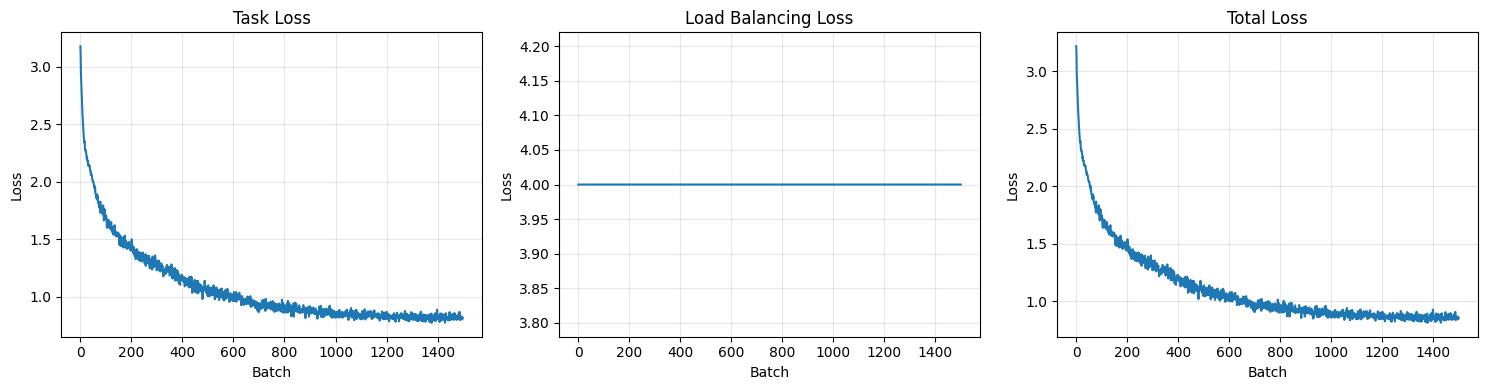


Final losses:
  Task Loss:   0.8164
  LB Loss:     4.0000
  Total Loss:  0.8564


In [23]:
# Plot training losses
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

axes[0].plot(task_losses)
axes[0].set_title('Task Loss')
axes[0].set_xlabel('Batch')
axes[0].set_ylabel('Loss')
axes[0].grid(True, alpha=0.3)

axes[1].plot(lb_losses)
axes[1].set_title('Load Balancing Loss')
axes[1].set_xlabel('Batch')
axes[1].set_ylabel('Loss')
axes[1].grid(True, alpha=0.3)

axes[2].plot(total_losses)
axes[2].set_title('Total Loss')
axes[2].set_xlabel('Batch')
axes[2].set_ylabel('Loss')
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\nFinal losses:")
print(f"  Task Loss:   {task_losses[-1]:.4f}")
print(f"  LB Loss:     {lb_losses[-1]:.4f}")
print(f"  Total Loss:  {total_losses[-1]:.4f}")


In [24]:
val = pd.read_csv("../data/val_4k.csv").iloc[:128]
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Fix: Use 'val' instead of 'df'
X_test = torch.tensor(val['seq'].apply(ast.literal_eval).tolist()).to(device)
print(f"Dataset size: {X_test.shape[0]} sequences")
print(f"Sequence length: {X_test.shape[1]}")
# Create loss mask (only compute loss on the output part)
loss_mask_test = torch.ones_like(X_test).to(device)
loss_mask_test[:, :10] = 0  # Don't compute loss on input
print(f"Loss mask: {loss_mask_test[0]}")

Using device: cuda
Dataset size: 128 sequences
Sequence length: 14
Loss mask: tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1], device='cuda:0')


In [25]:
# Evaluate model with batching to avoid OOM
model.eval()
batch_size = 256
num_batches = (X_test.shape[0] + batch_size - 1) // batch_size

all_losses = []

with torch.no_grad():
    for i in range(num_batches):
        start_idx = i * batch_size
        end_idx = min((i + 1) * batch_size, X_test.shape[0])
        
        batch_x = X_test[start_idx:end_idx]
        batch_mask = loss_mask_test[start_idx:end_idx]  # Use correct mask
        
        # Forward pass
        x_emb = model.encoder(batch_x)
        y_emb, lb_loss = model.forward(x_emb[:, :-1], return_load_balance_loss=True)
        y_hat = model.decoder(y_emb)
        
        # Task loss (cross entropy)
        loss = F.cross_entropy(
            input=y_hat.permute(0, 2, 1),
            target=batch_x[:, 1:],
            reduction="none"
        )
        masked_loss = loss * batch_mask[:, 1:]

        
        batch_task_loss = masked_loss.mean() * 14/4
        all_losses.append(batch_task_loss.item())
        

# Average loss across all batches
task_loss = sum(all_losses) / len(all_losses)
print(f"Validation Loss: {task_loss:.4f}")
        

Validation Loss: 0.8174


In [26]:
all_losses

[0.8173931837081909]

In [27]:
masked_loss[:, 10:].flatten()

tensor([6.3577e-01, 3.5648e-03, 1.6904e+00, 3.9585e-01, 5.9322e-02, 2.1880e+00,
        2.4208e-01, 1.5089e-02, 2.4049e+00, 2.3447e-01, 6.5400e-02, 2.5569e+00,
        1.7136e+00, 3.6813e-03, 2.2709e+00, 9.5001e-02, 1.4440e-02, 2.2591e+00,
        9.7455e-01, 3.9055e-03, 1.7893e+00, 1.9757e-03, 8.5479e-03, 2.7361e+00,
        6.9357e-01, 2.9168e-01, 2.4828e+00, 3.4349e-02, 6.4353e-03, 2.1357e+00,
        1.4726e-01, 7.5177e-02, 1.8524e+00, 3.7199e-01, 2.3448e-02, 3.1483e+00,
        3.4423e-03, 5.8699e-02, 2.3842e+00, 2.0042e-01, 2.5963e-02, 3.1008e+00,
        8.7614e-01, 3.5747e-02, 2.4748e+00, 7.9433e-01, 6.2720e-03, 2.1243e+00,
        4.0897e-01, 3.9485e-03, 2.3195e+00, 6.0826e-01, 9.8724e-03, 3.0972e+00,
        1.4510e+00, 9.5995e-03, 3.1168e+00, 7.0478e-01, 8.2886e-03, 2.4115e+00,
        1.1397e+00, 5.8309e-03, 2.1832e+00, 1.4033e-02, 1.0227e-02, 3.1847e+00,
        8.2127e-01, 5.1551e-02, 2.2832e+00, 2.5802e-03, 5.6321e-02, 2.6687e+00,
        2.9679e-02, 9.7395e-03, 1.9978e+

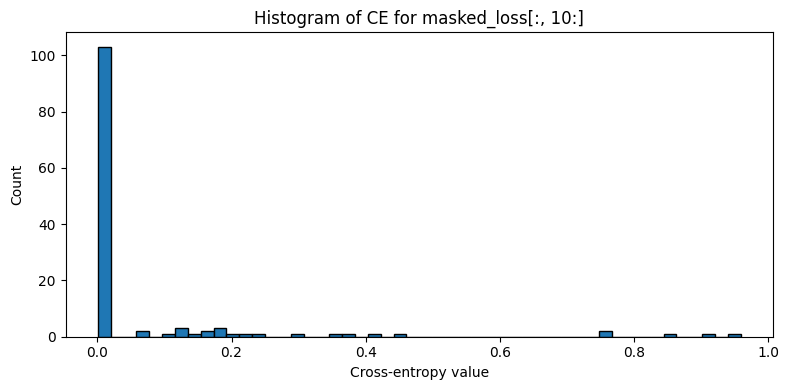

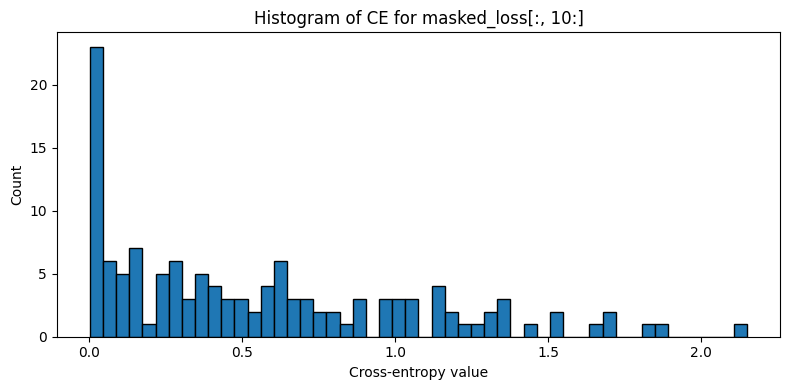

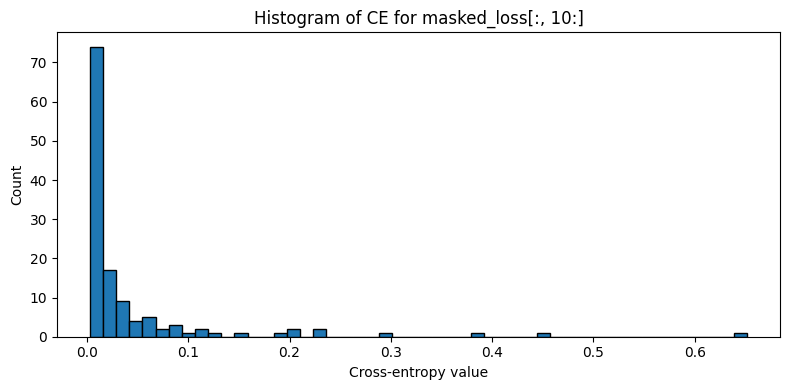

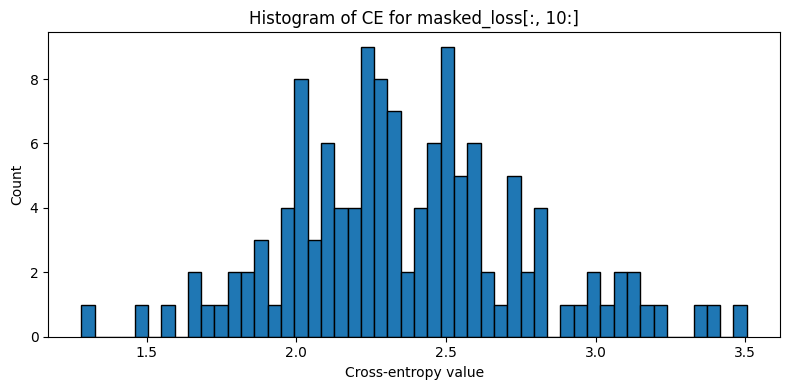

In [29]:
import matplotlib.pyplot as plt
import torch

def plot(idx):
    # Get values as a flat 1D numpy array
    vals = masked_loss[:, idx[0]:idx[1]].flatten().detach().cpu().numpy()

    plt.figure(figsize=(8, 4))

    # Histogram (“bucketed” counts)
    plt.hist(vals, bins=50, edgecolor='black')

    plt.xlabel("Cross-entropy value")
    plt.ylabel("Count")
    plt.title("Histogram of CE for masked_loss[:, 10:]")

    plt.tight_layout()
    plt.show()

for i in range(9,13):
    plot((i, i+1))
